<a href="https://colab.research.google.com/github/PYDIMARRI-HEMA-HARSHINI-23-586/Dog-Breed-Classification/blob/main/Dog_Breed_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hema123ameh","key":"e83daa0a4b77c1a6f8f4190486fe01b2"}'}

In [2]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [3]:
!kaggle competitions download -c dog-breed-identification


dog-breed-identification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import cv2
import tensorflow as tf
from tensorflow import keras
from keras import layers
from functools import partial

import warnings
warnings.filterwarnings('ignore')
AUTO = tf.data.experimental.AUTOTUNE

In [5]:
from zipfile import ZipFile
data_path = 'dog-breed-identification.zip'

with ZipFile(data_path, 'r') as zip:
    zip.extractall()
    print('The data set has been extracted.')

The data set has been extracted.


In [6]:
df = pd.read_csv('labels.csv')
df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [7]:
df.shape

(10222, 2)

In [8]:
df['breed'].nunique()

120

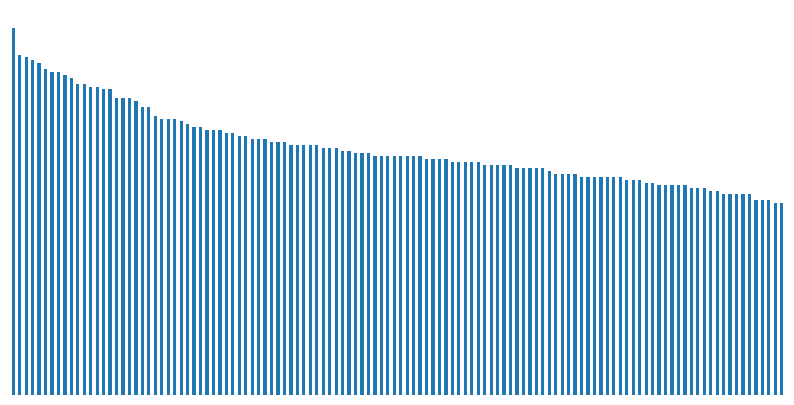

In [9]:
plt.figure(figsize=(10, 5))
df['breed'].value_counts().plot.bar()
plt.axis('off')
plt.show()

In [10]:
df['filepath'] = 'train/' + df['id'] + '.jpg'
df.head()

,id,breed,filepath
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,train/000bec180eb18c7604dcecc8fe0dba07.jpg
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,train/001513dfcb2ffafc82cccf4d8bbaba97.jpg
2,001cdf01b096e06d78e9e5112d419397,pekinese,train/001cdf01b096e06d78e9e5112d419397.jpg
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,train/00214f311d5d2247d5dfe4fe24b2303d.jpg
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,train/0021f9ceb3235effd7fcde7f7538ed62.jpg


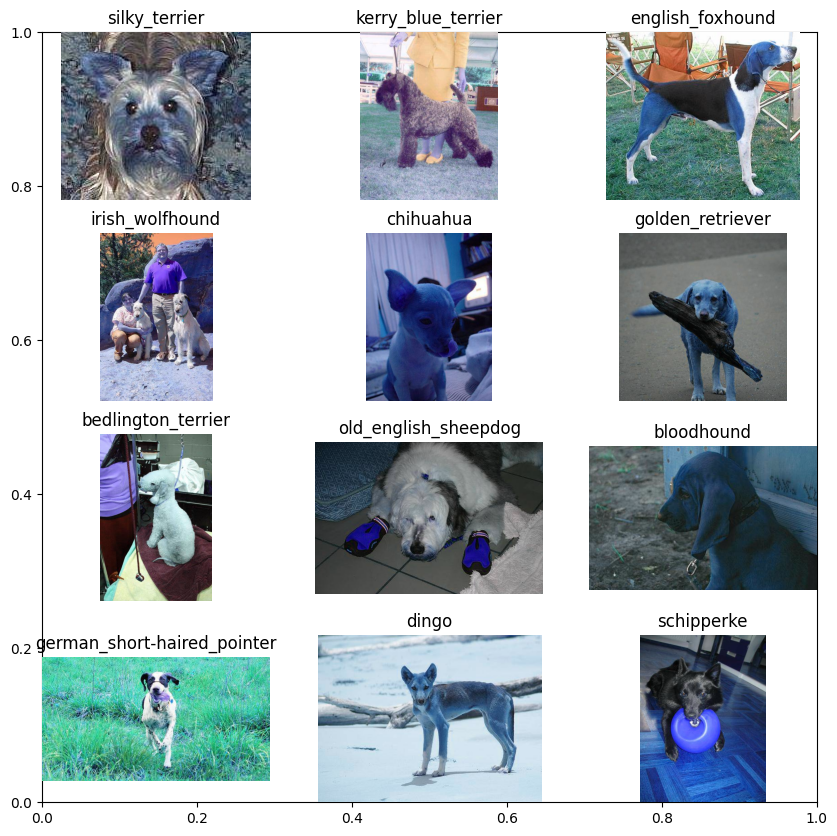

In [11]:
plt.subplots(figsize=(10, 10))
for i in range(12):
    plt.subplot(4, 3, i+1)

    # Selecting a random image
    # index from the dataframe.
    k = np.random.randint(0, len(df))
    img = cv2.imread(df.loc[k, 'filepath'])
    plt.imshow(img)
    plt.title(df.loc[k, 'breed'])
    plt.axis('off')
plt.show()

In [12]:
le = LabelEncoder()
df['breed'] = le.fit_transform(df['breed'])
df.head()

,id,breed,filepath
0,000bec180eb18c7604dcecc8fe0dba07,19,train/000bec180eb18c7604dcecc8fe0dba07.jpg
1,001513dfcb2ffafc82cccf4d8bbaba97,37,train/001513dfcb2ffafc82cccf4d8bbaba97.jpg
2,001cdf01b096e06d78e9e5112d419397,85,train/001cdf01b096e06d78e9e5112d419397.jpg
3,00214f311d5d2247d5dfe4fe24b2303d,15,train/00214f311d5d2247d5dfe4fe24b2303d.jpg
4,0021f9ceb3235effd7fcde7f7538ed62,49,train/0021f9ceb3235effd7fcde7f7538ed62.jpg


In [13]:
features = df['filepath']
target = df['breed']

X_train, X_val, Y_train, Y_val = train_test_split(features, target,
                                      test_size=0.15,
                                      random_state=10)

X_train.shape, X_val.shape

((8688,), (1534,))

In [14]:
import albumentations as A

transforms_train = A.Compose([
    A.VerticalFlip(p=0.2),
    A.HorizontalFlip(p=0.7),
    A.CoarseDropout(p=0.5),
    A.RandomGamma(p=0.5),
    A.RandomBrightnessContrast(p=1)
])

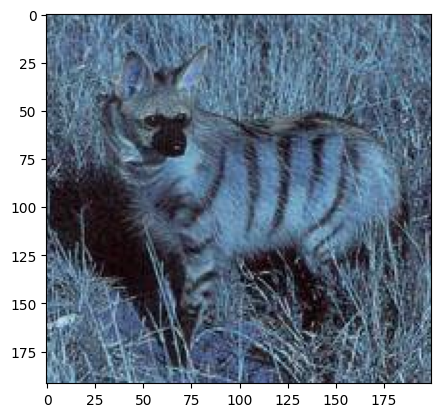

In [15]:
img = cv2.imread('train/00792e341f3c6eb33663e415d0715370.jpg')
plt.imshow(img)
plt.show()

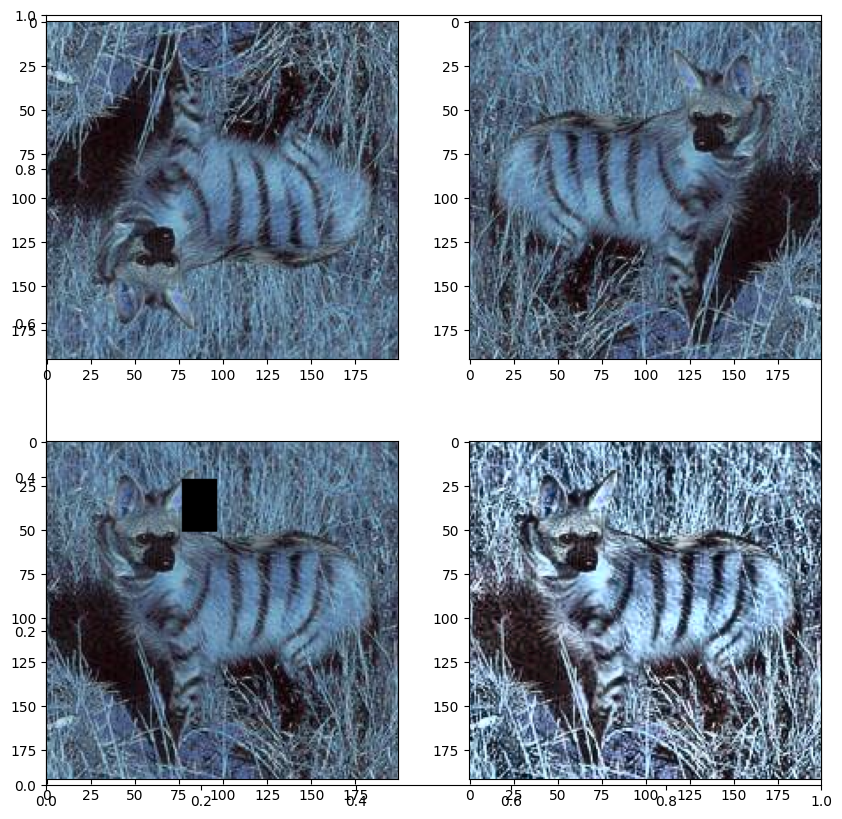

In [16]:
augments = [A.VerticalFlip(p=1), A.HorizontalFlip(p=1),
            A.CoarseDropout(p=1), A.CLAHE(p=1)]

plt.subplots(figsize=(10, 10))
for i, aug in enumerate(augments):
    plt.subplot(2, 2, i+1)
    aug_img = aug(image=img)['image']
    plt.imshow(aug_img)
plt.show()

In [17]:
def aug_fn(img):
    aug_data = transforms_train(image=img)
    aug_img = aug_data['image']

    return aug_img


@tf.function
def process_data(img, label):
    aug_img = tf.numpy_function(aug_fn,
                                [img],
                                Tout=tf.float32)

    return img, label


def decode_image(filepath, label=None):

    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, [128, 128])
    img = tf.cast(img, tf.float32) / 255.0

    if label == None:
        return img

    return img, tf.one_hot(indices=label,
                           depth=120,
                           dtype=tf.float32)

In [18]:
train_ds = (
    tf.data.Dataset
    .from_tensor_slices((X_train, Y_train))
    .map(decode_image, num_parallel_calls=AUTO)
    .map(partial(process_data), num_parallel_calls=AUTO)
    .batch(32)
    .prefetch(AUTO)
)

val_ds = (
    tf.data.Dataset
    .from_tensor_slices((X_val, Y_val))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(32)
    .prefetch(AUTO)
)

In [19]:
for img, label in train_ds.take(1):
  print(img.shape, label.shape)

(32, 128, 128, 3) (32, 120)


In [20]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

pre_trained_model = InceptionV3(
    input_shape=(128, 128, 3),
    weights='imagenet',
    include_top=False
)

In [21]:
len(pre_trained_model.layers)

311

In [22]:
for layer in pre_trained_model.layers:
  layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed7')
# Access the output shape from the output tensor of the layer
print('last layer output shape: ', last_layer.output.shape)
last_output = last_layer.output

last layer output shape:  (None, 6, 6, 768)


In [23]:
# Model Architecture
x = layers.Flatten()(last_output)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)
output = layers.Dense(120, activation='softmax')(x)

model = keras.Model(pre_trained_model.input, output)

# Model Compilation
model.compile(
	optimizer='adam',
	loss=keras.losses.CategoricalCrossentropy(from_logits=True),
	metrics=[tf.keras.metrics.AUC()]
)

In [24]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

class myCallback(tf.keras.callbacks.Callback):
	def on_epoch_end(self, epoch, logs={}):
		if logs.get('val_auc') is not None and logs.get('val_auc') > 0.99:
			print('\n Validation accuracy has reached upto 90% so, stopping further training.')
			self.model.stop_training = True

es = EarlyStopping(patience=3,
                monitor='val_auc',
                restore_best_weights=True,
                mode='max')

lr = ReduceLROnPlateau(monitor='val_loss',
					patience=2,
					factor=0.5,
					verbose=1)

In [25]:
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=50,
                    verbose=1,
                    callbacks=[es, lr, myCallback()])

Epoch 1/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 365s 1s/step - auc: 0.7128 - loss: 4.3622 - val_auc: 0.9369 - val_loss: 2.5506 - learning_rate: 0.0010
Epoch 2/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 354s 1s/step - auc: 0.9636 - loss: 2.2126 - val_auc: 0.9415 - val_loss: 2.3383 - learning_rate: 0.0010
Epoch 3/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 353s 1s/step - auc: 0.9910 - loss: 1.1922 - val_auc: 0.9274 - val_loss: 2.4042 - learning_rate: 0.0010
Epoch 4/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 979ms/step - auc: 0.9990 - loss: 0.5098
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
272/272 ━━━━━━━━━━━━━━━━━━━━ 349s 1s/step - auc: 0.9990 - loss: 0.5094 - val_auc: 0.9189 - val_loss: 2.4415 - learning_rate: 0.0010
Epoch 5/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 346s 1s/step - auc: 1.0000 - loss: 0.1789 - val_auc: 0.9267 - val_loss: 2.3384 - learning_rate: 5.0000e-04


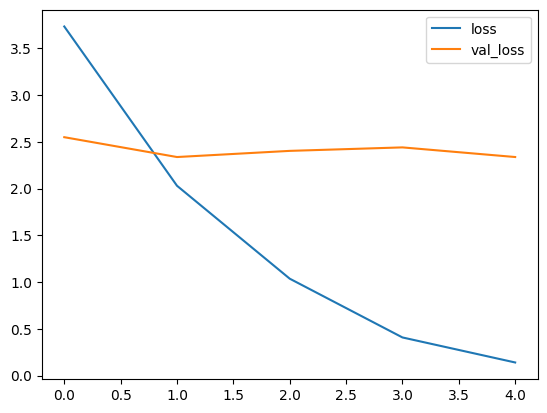

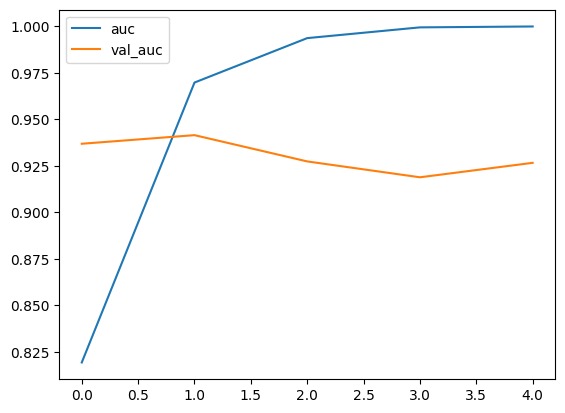

In [26]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['auc', 'val_auc']].plot()
plt.show()

In [27]:
import os

test_dir = "test"

test_files = sorted([
    os.path.join(test_dir, f)
    for f in os.listdir(test_dir)
    if f.endswith(".jpg")
])

len(test_files)


10357

In [28]:
def decode_test_image(filepath):
    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, [128, 128])
    img = tf.cast(img, tf.float32) / 255.0
    return img


In [29]:
test_ds = (
    tf.data.Dataset
    .from_tensor_slices(test_files)
    .map(decode_test_image, num_parallel_calls=AUTO)
    .batch(32)
    .prefetch(AUTO)
)


In [30]:
preds = model.predict(test_ds, verbose=1)
preds.shape


324/324 ━━━━━━━━━━━━━━━━━━━━ 298s 892ms/step


(10357, 120)

In [31]:
breed_names = le.inverse_transform(np.arange(120))
top_preds = [breed_names[np.argmax(p)] for p in preds]


In [32]:
test_ids = [
    os.path.basename(path).replace(".jpg", "")
    for path in test_files
]


In [33]:
import pandas as pd
results = pd.DataFrame({
    "id": test_ids,
    "breed": top_preds
})
results.to_csv("submission.csv", index=False)


In [34]:
from google.colab import files
files.download("submission.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [45]:
from google.colab import files
uploaded = files.upload()


Saving hema_yellow.jpg to hema_yellow.jpg


In [36]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

def predict_dog_breed(img_path):
    # Read image
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, [128, 128])
    img = tf.cast(img, tf.float32) / 255.0

    # Expand dims → (1,128,128,3)
    img = tf.expand_dims(img, axis=0)

    # Predict
    pred = model.predict(img)[0]

    # Get top class
    top_idx = np.argmax(pred)
    top_breed = le.inverse_transform([top_idx])[0]
    top_prob = pred[top_idx]

    # Display image + prediction
    plt.imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
    plt.title(f"Predicted: {top_breed}\nConfidence: {top_prob:.3f}")
    plt.axis('off')
    plt.show()

    return top_breed, top_prob


In [43]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

def predict_with_cutoff(img_path, threshold=0.10):
    # Read + preprocess
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, [128,128])
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.expand_dims(img, 0)

    # Predict
    probs = model.predict(img)[0]
    top_idx = np.argmax(probs)
    top_prob = float(probs[top_idx])

    # If top probability < threshold → not a dog
    if top_prob < threshold:
        print(f"Prediction: NOT A DOG (confidence = {top_prob:.3f})")
        return "not_dog", top_prob

    # Else → return predicted breed
    breed = le.inverse_transform([top_idx])[0]

    print(f"Prediction: {breed} (confidence = {top_prob:.3f})")

    # Show image
    plt.imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
    plt.title(f"{breed} ({top_prob:.3f})")
    plt.axis('off')
    plt.show()

    return breed, top_prob


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


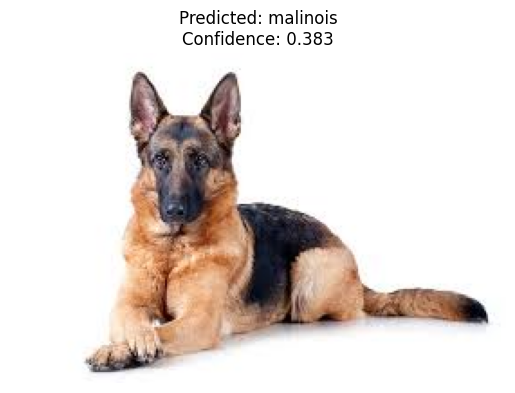

('malinois', np.float32(0.3825866))

In [47]:
predict_dog_breed("download.jpg")

In [38]:
def predict_top5(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, [128, 128])
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.expand_dims(img, axis=0)

    pred = model.predict(img)[0]

    top5 = pred.argsort()[-5:][::-1]
    breeds = le.inverse_transform(top5)

    for b in top5:
        print(f"{le.inverse_transform([b])[0]} → {pred[b]:.3f}")


In [39]:
predict_top5("download.jpg")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
malinois → 0.383
german_shepherd → 0.244
kelpie → 0.100
miniature_pinscher → 0.040
african_hunting_dog → 0.022


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
Prediction: malinois (confidence = 0.383)


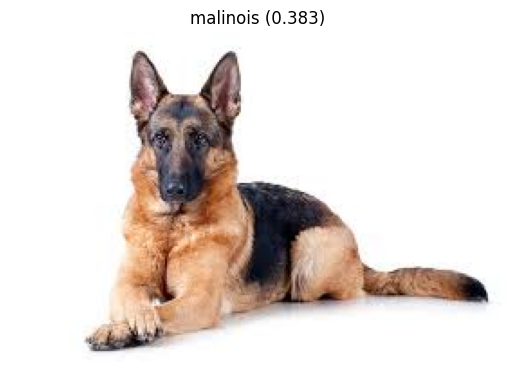

('malinois', 0.38258659839630127)

In [49]:
predict_with_cutoff("download.jpg", threshold=0.10)
